# Importing libraries

In [18]:
import cv2
import numpy as np
import imutils
import easyocr
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt


# Loading the Training Dataset

In [19]:
video_path = r"C:\Users\manas\OneDrive\Desktop\WhatsApp Video 2024-06-08 at 11.46.07 (1).mp4"  # Update with your video file path
output_csv_path = r"C:\Users\manas\OneDrive\Desktop\text analytics\detected_number_plates.csv"
training_csv_path = r"C:\Users\manas\OneDrive\Desktop\text analytics\Training vehicle_number plate.csv"  # Path to training dataset

# Load the training dataset into a set for quick lookup
try:
    with open(training_csv_path, mode='r', encoding='utf-8') as training_file:
        csv_reader = csv.reader(training_file)
        next(csv_reader)  # Skip the header row
        training_plates = set(row[0].strip() for row in csv_reader if row)
except FileNotFoundError:
    print(f"Error: Training dataset not found at {training_csv_path}.")
    exit()

# Writing to the Output CSV

In [20]:
# Create the output CSV file with headers if it doesn't exist
with open(output_csv_path, mode='w', newline='', encoding='utf-8') as output_file:
    csv_writer = csv.writer(output_file)
    # Write the headers
    csv_writer.writerow(["Date", "Time", "Number Plate"])

# Processing Each Video Frame

In [21]:
# Initialize a set to track already saved number plates
detected_plates = set()

# Function to process each frame and save valid detections to the output CSV
def process_frame(frame, reader):
    global detected_plates

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply bilateral filter to reduce noise
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)

    # Detect edges using Canny edge detection
    edged = cv2.Canny(bfilter, 30, 200)

    # Find contours in the edged image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # Initialize location variable
    location = None

    # Loop through contours to find the best approximated polygon for the plate
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
    if location is not None:
        # Create a mask for the number plate
        mask = np.zeros(gray.shape, np.uint8)
        new_image = cv2.drawContours(mask, [location], 0, 255, -1)
        new_image = cv2.bitwise_and(frame, frame, mask=mask)

        # Extract the coordinates of the number plate
        (x, y) = np.where(mask == 255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))

        # Crop the plate area from the grayscale image
        cropped_image = gray[x1:x2+1, y1:y2+1]

        # Use EasyOCR to read text from the cropped image
        result = reader.readtext(cropped_image)

        # If text is detected, process it
        if result:
            text = result[0][1].strip()

            # Check if the plate meets criteria and is in the training dataset
            if text in training_plates and text not in detected_plates:
                # Add to the set of detected plates
                detected_plates.add(text)

                # Get current date and time
                current_time = datetime.now()
                date = current_time.strftime('%Y-%m-%d')
                time = current_time.strftime('%H:%M:%S')
  # Save to the output CSV file
                with open(output_csv_path, mode='a', newline='', encoding='utf-8') as output_file:
                    csv_writer = csv.writer(output_file)
                    csv_writer.writerow([date, time, text])

                # Display detected plate on the frame
                cv2.putText(frame, text, (location[0][0][0], location[1][0][1] + 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.rectangle(frame, tuple(location[0][0]), tuple(location[2][0]), (0, 255, 0), 3)

    return frame

# Video Capture and Processing Loop

In [22]:
# Load the video stream
cap = cv2.VideoCapture(video_path)

# Check if the video stream was opened successfully
if not cap.isOpened():
    print("Error: Unable to open video stream.")
    exit()

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # If the frame was not captured successfully, break the loop
    if not ret:
        break

    # Process the frame
    processed_frame = process_frame(frame, reader)

    # Show the video stream with the detected number plate
    cv2.imshow("Number Plate Detection", processed_frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


 # Data Visualization

# Bar Chart for Number Plates Detected by Date

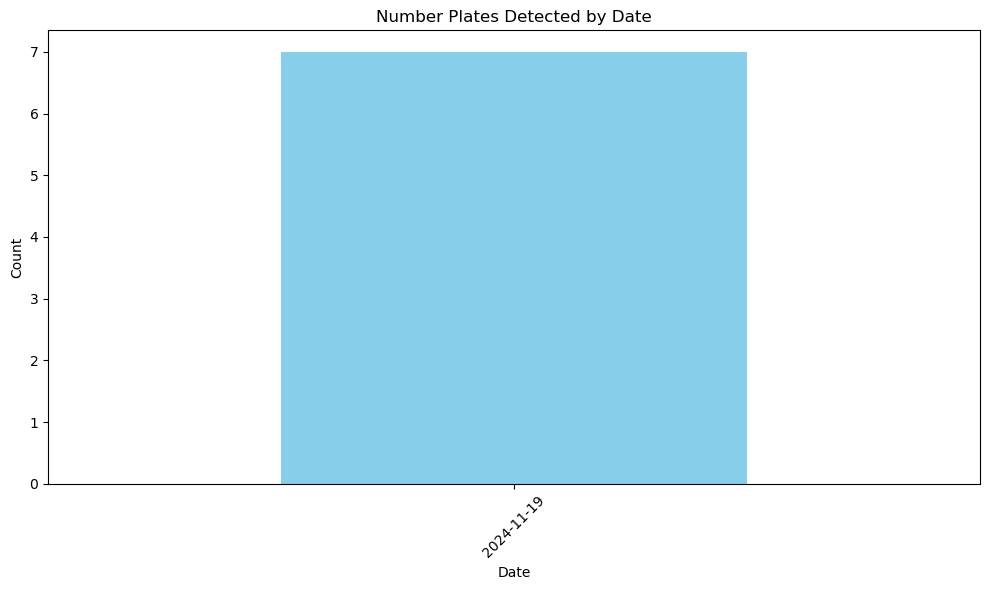

In [23]:
# Visualization Code
def visualize_results(csv_path):
    df = pd.read_csv(csv_path)

    # Plot 1: Bar chart of detections by date
    plt.figure(figsize=(10, 6))
    date_counts = df['Date'].value_counts()
    date_counts.plot(kind='bar', color='skyblue')
    plt.title("Number Plates Detected by Date")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# Call the visualization function
visualize_results(output_csv_path)

# Time-Series Line Chart for Detections Over Time

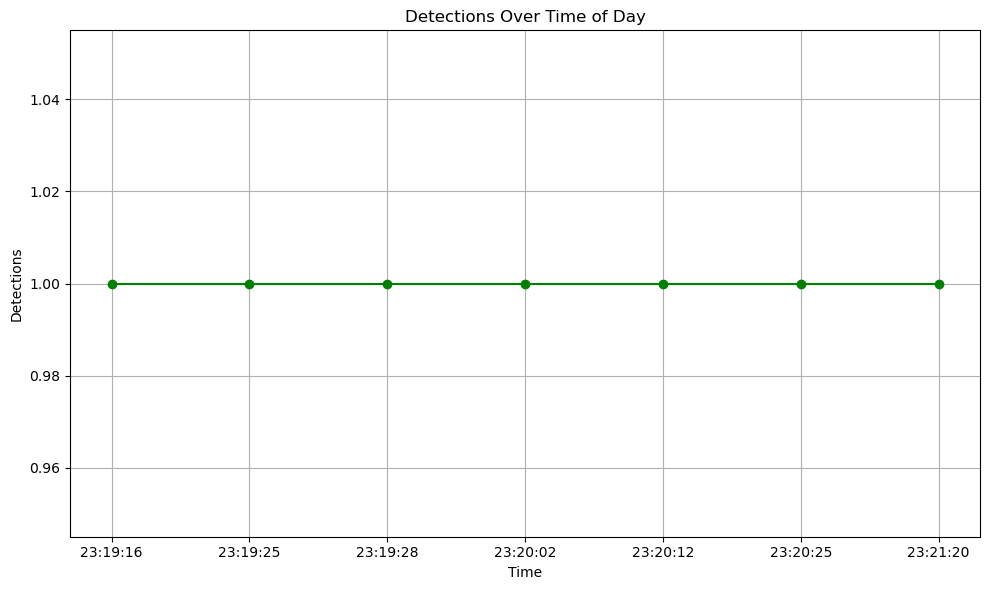

In [24]:
def visualize_results(csv_path):
    # Load the detected data
    df = pd.read_csv(csv_path)

# Plot 2: Time-series detections by time of day
    plt.figure(figsize=(10, 6))
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
    df['Time'] = df['Time'].astype(str)  # Convert to string for grouping
    time_counts = df['Time'].value_counts().sort_index()
    time_counts.plot(kind='line', marker='o', color='green')
    plt.title("Detections Over Time of Day")
    plt.xlabel("Time")
    plt.ylabel("Detections")
    plt.grid()
    plt.tight_layout()
    plt.show()
# Call the visualization function
visualize_results(output_csv_path)

# Pie Chart for Unique Number Plates Detected

In [25]:
def visualize_results(csv_path):
    # Load the detected data
    df = pd.read_csv(csv_path)


     # Plot 3: Pie chart of unique number plates detected
    plt.figure(figsize=(8, 8))
    plate_counts = df['Number Plate'].value_counts()
    plate_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title("Proportion of Unique Number Plates Detected")
    plt.ylabel("")  # Remove y-axis label
    plt.tight_layout()
    plt.show()
# Call the visualization function
visualize_results(output_csv_path)

NameError: name 'sns' is not defined

<Figure size 800x800 with 0 Axes>

# Heatmap for Detection Frequency by Hour

In [ ]:
def visualize_results(csv_path):
    # Load the detected data
    df = pd.read_csv(csv_path)
 # Plot 4: Heatmap of detection frequency by hour
    df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
    hour_counts = df.groupby(['Date', 'Hour']).size().unstack(fill_value=0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(hour_counts, cmap="Blues", annot=True, fmt="d", cbar=True)
    plt.title("Detection Frequency Heatmap (by Hour)")
    plt.xlabel("Hour")
    plt.ylabel("Date")
    plt.tight_layout()
    plt.show()

     
# Call the visualization function
visualize_results(output_csv_path)